In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path, PurePath
from nilearn import image
from numpy.lib import recfunctions
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nilearn.glm.first_level import FirstLevelModel
from load_confounds import Params36,Params24
from nilearn.plotting import plot_design_matrix
from sklearn.model_selection import LeaveOneGroupOut
from nilearn.decoding import Decoder

/home/SRastegarnia/.local/lib/python3.6/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


In [2]:
scan_file_1 = '/data/neuromod/DATA/cneuromod/hcptrt/derivatives/fmriprep-20.1.0/fmriprep/sub-01/ses-001/'+\
              'func/sub-01_ses-001_task-motor_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

events_file_1 = '/data/neuromod/DATA/cneuromod/hcptrt/sub-01/ses-001/func/'+\
                'sub-01_ses-001_task-motor_run-01_events.tsv'

df = pd.read_table(events_file_1)
print("scan file shape:", image.load_img(scan_file_1).shape)
print("events file shape:" , df.shape)
df.head()
# df.to_csv('sub-01_ses-001_task-motor_run-01_events.csv') 

scan file shape: (97, 115, 97, 144)
events file shape: (117, 5)


,trial_type,nbloc,onset,duration,countdown_stim
0,countdown,NaN,0.000,1.984,4.0
1,countdown,NaN,1.999,1.985,3.0
2,countdown,NaN,3.999,1.985,2.0
3,countdown,NaN,5.999,1.985,1.0
4,new_bloc_left_hand,1.0,8.016,2.983,NaN


In [3]:
datapath = '../DATA/cneuromod/hcptrt/sub-01'
func = 'space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
regr = 'desc-confounds_regressors.tsv'
ev = 'events.tsv'
task_label = 'motor'
mas = 'space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
# subject = func.split('_ses')[0]
subject = 'sub-01'
#######################
# fname = 'Benchmark_results'
#######################
scans = sorted(Path(datapath).rglob('*_task-{}*{}'.format(task_label, func)))
scans = [str(s) for s in scans]

regressors = sorted(Path(datapath).rglob('*_task-{}*{}'.format(task_label, regr)))
regressors = [str(r) for r in regressors]
              
events = sorted(Path(datapath).rglob('*_task-{}*{}'.format(task_label, ev)))
events = [str(e) for e in events]

masks = sorted(Path(datapath).rglob('*_task-{}*{}'.format(task_label, mas)))
masks = [str(e) for e in masks]
print("mask files shape:", image.load_img(masks[0]).shape)

# mask_file = '/data/neuromod/DATA/cneuromod/hcptrt/derivatives/fmriprep-20.1.0/fmriprep/sub-01/ses-001/func/'+\
#             'sub-01_ses-001_task-motor_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'

# print(*events)
# print(type(events))
# print(len(events))

if (len(scans) != len(events)) and (len(regressors) != len(masks)) and \
   (len(scans) != len(masks)):
    err_msg = ("The number of BOLD, event, mask and confound files" +
               "must match.")
    raise ValueError(err_msg)

mask files shape: (97, 115, 97)


In [4]:
# generating confounds file
confounds_idx = []
for scan in (scans):
    confounds = Params36().load(scan)
    confounds = pd.DataFrame.from_records(confounds)
    confounds_idx.append(confounds)

print(confounds_idx)
# confounds = confounds.values.tolist()
print(len(confounds_idx))

/home/SRastegarnia/.local/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/SRastegarnia/.local/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/SRastegarnia/.local/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


[           0         1         2         3         4         5             6   \
0   -0.000276  0.009050  0.048650 -0.000529 -0.000027 -0.000002  1.609363e-20   
1   -0.000276  0.009050  0.056533 -0.000529 -0.000027 -0.000002  1.609363e-20   
2   -0.000276  0.047012  0.052424 -0.000641 -0.000027 -0.000002  1.609363e-20   
3   -0.000273  0.042812  0.042419 -0.000695 -0.000006 -0.000002  3.082520e-06   
4   -0.000255  0.017407  0.042319 -0.000630  0.000012 -0.000002  1.738598e-05   
..        ...       ...       ...       ...       ...       ...           ...   
139 -0.000119 -0.011665 -0.007230 -0.000095  0.000066 -0.000002 -4.470000e-07   
140 -0.000098 -0.065884 -0.007550  0.000023  0.000039 -0.000002  2.087200e-05   
141 -0.000117  0.009545 -0.028093 -0.000722  0.000048 -0.000002 -1.909800e-05   
142 -0.000097  0.003617 -0.011798 -0.000105  0.000122 -0.000002  2.060000e-05   
143 -0.000276  0.009050 -0.018888 -0.000529 -0.000027 -0.000002 -1.792160e-04   

           7         8    

In [5]:
# motor task conditions
category = df.trial_type.str.split('_', n=1, expand=True)[1]
categories = list(df.trial_type)
print(categories, '\n')

# print("number of conditions =" , len(categories))

# conditions = list(set(df['trial_type']))
conditions = list(set(df['trial_type']))
print("number of unique categories:" ,  len(conditions),'\n')
print(conditions)

['countdown', 'countdown', 'countdown', 'countdown', 'new_bloc_left_hand', 'response_left_hand', 'response_left_hand', 'response_left_hand', 'response_left_hand', 'response_left_hand', 'response_left_hand', 'response_left_hand', 'response_left_hand', 'response_left_hand', 'response_left_hand', 'new_bloc_right_foot', 'response_right_foot', 'response_right_foot', 'response_right_foot', 'response_right_foot', 'response_right_foot', 'response_right_foot', 'response_right_foot', 'response_right_foot', 'response_right_foot', 'response_right_foot', 'cross_fixation', 'new_bloc_tongue', 'response_tongue', 'response_tongue', 'response_tongue', 'response_tongue', 'response_tongue', 'response_tongue', 'response_tongue', 'response_tongue', 'response_tongue', 'response_tongue', 'new_bloc_left_foot', 'response_left_foot', 'response_left_foot', 'response_left_foot', 'response_left_foot', 'response_left_foot', 'response_left_foot', 'response_left_foot', 'response_left_foot', 'response_left_foot', 'resp

In [6]:
glm_idx = []
for i in range(10):
    glm = FirstLevelModel(mask_img=masks[i], t_r=1.49, high_pass=0.01,
                          smoothing_fwhm=5, standardize=True)
    glm = glm.fit(scans[i], events=events[i], confounds=confounds_idx[i])
    glm_idx.append(glm)  

/home/SRastegarnia/.local/lib/python3.6/site-packages/nilearn/_utils/glm.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')
/home/SRastegarnia/.local/lib/python3.6/site-packages/nilearn/_utils/glm.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')
/home/SRastegarnia/.local/lib/python3.6/site-packages/nilearn/_utils/glm.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')
/home/SRastegarnia/.local/lib/python3.6/site-packages/nilearn/_utils/glm.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')
/home/SRastegarnia/.local/lib/python3.6/site-packages/nilearn/_utils/glm.py:276: UserWarning: Matrix is singular at working prec

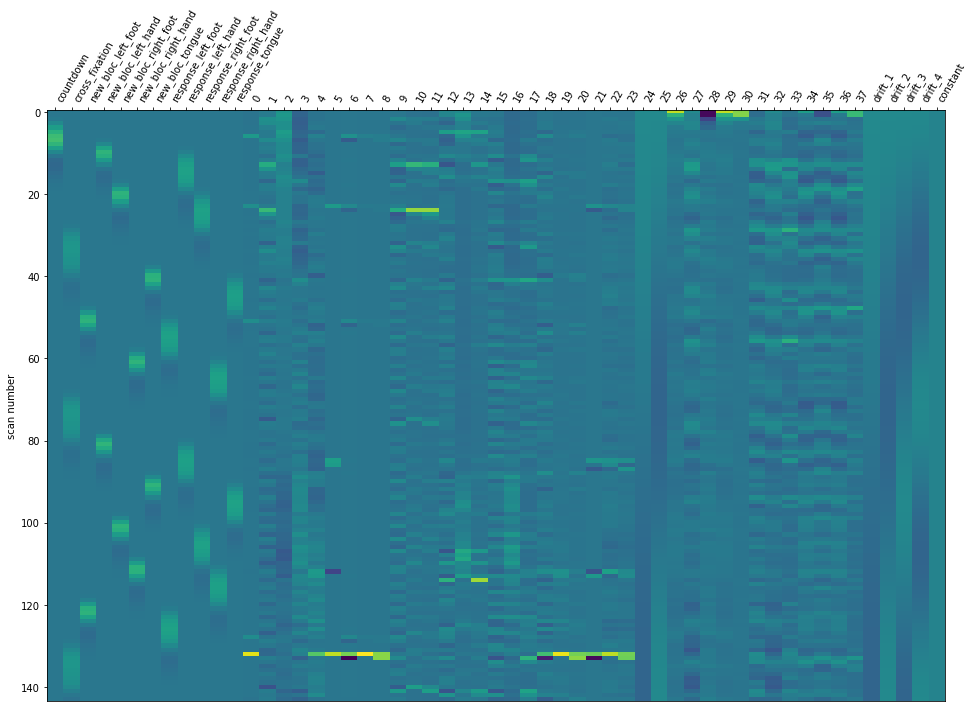

FirstLevelModel(mask_img='../DATA/cneuromod/hcptrt/sub-01/sub-01_ses-001_task-motor_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz',
                signal_scaling=True, smoothing_fwhm=5, t_r=1.49)


In [7]:
# using nilearn.plotting.plot_design_matrix to visualize the design matrix: 
design_matrix = glm_idx[0].design_matrices_[0]
plot_design_matrix(design_matrix)
plt.show()

print(glm_idx[0])

In [8]:
# # or maybe the mask should be generated using NiftiLabelsMasker??

# masker = NiftiLabelsMasker(labels_img='MIST_444.nii.gz', standardize=True, 
#                            detrend=False, smoothing_fwhm=8).fit()
# Data_fmri = masker.transform(scan_files, confounds=Params24().load(scan_files))

# print(type(Data_fmri))
# print(Data_fmri.shape)

# Data_fmri.view()

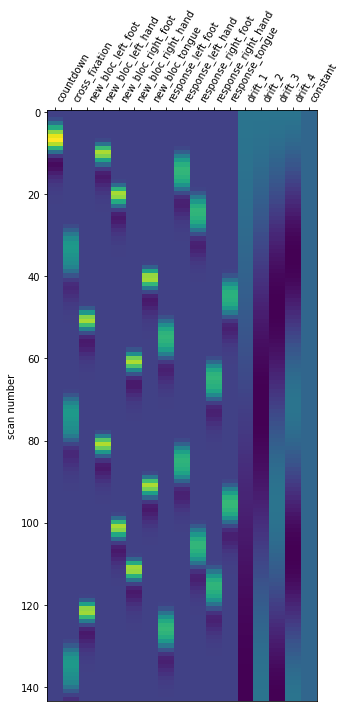

In [9]:
# The design matrix has 12 main columns corresponding to 12 experimental categories, followed by 
# 4 columns describing low-frequency signals (drifts) and a constant regressor.

glm_temp = FirstLevelModel(mask_img=masks[0], t_r=1.49, high_pass=0.01, 
                           smoothing_fwhm=5, standardize=True)
glm_temp.fit(scans[0], events=events[0]) # without loading confounds
design_matrix = glm_temp.design_matrices_[0]
plot_design_matrix(design_matrix)
plt.show()

In [10]:
# session_1 = scans[0].partition('_')[2].split('_task')[0]
# glm_idx[0].fit(run_imgs=scans[0], events=events[0], confounds=confounds_idx[0])
  
# for condition in conditions:
#     z_maps.append(glm_idx[0].compute_contrast(condition))
#     condition_idx.append(condition)
#     session_idx.append(session)

In [11]:
z_maps, condition_idx, runs_idx, session_idx = [], [], [], []
for i in range(10):
    session = scans[i].partition('_')[2].split('_task')[0]
    glm_idx[i].fit(run_imgs=scans[i], events=events[i],
                   confounds=confounds_idx[i])
    print(session)
    
    for condition in conditions:
        z_maps.append(glm_idx[i].compute_contrast(condition))
        condition_idx.append(condition)
        runs_idx.append(session)
    session_idx.append(session)   

/home/SRastegarnia/.local/lib/python3.6/site-packages/nilearn/_utils/glm.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


ses-001


/home/SRastegarnia/.local/lib/python3.6/site-packages/nilearn/_utils/glm.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


ses-002


/home/SRastegarnia/.local/lib/python3.6/site-packages/nilearn/_utils/glm.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


ses-003


/home/SRastegarnia/.local/lib/python3.6/site-packages/nilearn/_utils/glm.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


ses-004


/home/SRastegarnia/.local/lib/python3.6/site-packages/nilearn/_utils/glm.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


ses-005


/home/SRastegarnia/.local/lib/python3.6/site-packages/nilearn/_utils/glm.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


ses-006


/home/SRastegarnia/.local/lib/python3.6/site-packages/nilearn/_utils/glm.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


ses-007


/home/SRastegarnia/.local/lib/python3.6/site-packages/nilearn/_utils/glm.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


ses-008


/home/SRastegarnia/.local/lib/python3.6/site-packages/nilearn/_utils/glm.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


ses-009


/home/SRastegarnia/.local/lib/python3.6/site-packages/nilearn/_utils/glm.py:276: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


ses-010


In [12]:
print(session_idx,'\n')
print(runs_idx)

['ses-001', 'ses-002', 'ses-003', 'ses-004', 'ses-005', 'ses-006', 'ses-007', 'ses-008', 'ses-009', 'ses-010'] 

['ses-001', 'ses-001', 'ses-001', 'ses-001', 'ses-001', 'ses-001', 'ses-001', 'ses-001', 'ses-001', 'ses-001', 'ses-001', 'ses-001', 'ses-002', 'ses-002', 'ses-002', 'ses-002', 'ses-002', 'ses-002', 'ses-002', 'ses-002', 'ses-002', 'ses-002', 'ses-002', 'ses-002', 'ses-003', 'ses-003', 'ses-003', 'ses-003', 'ses-003', 'ses-003', 'ses-003', 'ses-003', 'ses-003', 'ses-003', 'ses-003', 'ses-003', 'ses-004', 'ses-004', 'ses-004', 'ses-004', 'ses-004', 'ses-004', 'ses-004', 'ses-004', 'ses-004', 'ses-004', 'ses-004', 'ses-004', 'ses-005', 'ses-005', 'ses-005', 'ses-005', 'ses-005', 'ses-005', 'ses-005', 'ses-005', 'ses-005', 'ses-005', 'ses-005', 'ses-005', 'ses-006', 'ses-006', 'ses-006', 'ses-006', 'ses-006', 'ses-006', 'ses-006', 'ses-006', 'ses-006', 'ses-006', 'ses-006', 'ses-006', 'ses-007', 'ses-007', 'ses-007', 'ses-007', 'ses-007', 'ses-007', 'ses-007', 'ses-007', 'ses-0

In [13]:
for i in range(10):
    fname='{}_{}_task-{}_{}'.format(subject, session_idx[i], task_label, 
                                 func.replace('preproc', 'postproc'))

    sid = fname.split('_')[0]
    nib.save(image.concat_imgs(z_maps), fname)
    np.savetxt('{}_labels.csv'.format(sid), condition_idx, fmt='%s')
    np.savetxt('{}_runs.csv'.format(sid), runs_idx, fmt='%s')

In [14]:
# Benchmark_labels = 'Benchmark_labels.csv'
# BL = pd.read_table(Benchmark_labels, header=None)

# print("events file shape:" , BL.shape)
# BL.head()

In [15]:
print("z_maps file shape:", image.load_img(z_maps).shape)
print("z_maps file shape:", image.load_img(z_maps[9]).shape)

z_maps file shape: (97, 115, 97, 120)
z_maps file shape: (97, 115, 97)


In [16]:
# relabeling conditions

# if task_label == 'motor':
#   events = [_relabel_motorwm_events(e) for e in events]
# else:
#   events = [pd.read_table(e) for e in events]

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [18]:
import sklearn
print (sklearn.__version__)

0.23.2


In [ ]:
con_idx.shape
ses_idx.shape

######################
decoder.fit(z_map, con_idx, groups=ses_idx)

In [ ]:
# Decoder
post_path = '/home/SRastegarnia/hcptrt_decoding_Shima/Benchmark_model'
task_label = 'motor'
z_maps = Path(post_path).rglob(f'*{task_label}*postproc_bold.nii.gz')
condition_labels = Path(post_path).rglob('*_labels.csv')
runs = Path(post_path).rglob('*_runs.csv')
mask = masks[0]

for z_map, condition, session in zip(z_maps, condition_labels, 
                                           runs):
    con_idx = pd.read_table(condition, header=None).values.ravel()
    ses_idx = pd.read_table(session, header=None).values.ravel()

# Leave One Group Out cross-validator: Provides train/test indices 
# to split data according to a third-party provided group. 
#     cv = model_selection.LeaveOneGroupOut()
    cv = model_selection.LeaveOneGroupOut()
# The Decoder object supports classification methods and implements a 
# model selection scheme that averages the best models within a cross validation
# loop. It also leverages the`NiftiMaskers` to provide a direct interface with 
# the Nifti files.    
    decoder = Decoder(estimator='svc', mask=mask, standardize=False, 
                      cv=cv, scoring='accuracy')   
    decoder.fit(z_map, con_idx, groups=ses_idx)
#     scores_dict = decoder.cv_scores_
#     for key in scores_dict:
#         print(key, np.mean(scores_dict[key]))

# ########################################
# condition_idx = pd.read_table(conditions, header=None).values.ravel()
# session_idx = pd.read_table(sessions, header=None).values.ravel()

# # Leave One Group Out cross-validator: Provides train/test indices to split data according to a third-party provided group. 
# cv = LeaveOneGroupOut()

# # The Decoder object supports classification methods and implements a model selection scheme that averages the best models 
# # within a cross validation loop. It also leverages the`NiftiMaskers` to provide a direct interface with the Nifti files.
# decoder = Decoder(estimator='svc', mask=masks, standardize=False, cv=cv,scoring='accuracy')
# decoder.fit(z_maps, condition_idx, groups=session_idx)

# # condition_idx = pd.read_table(conditions, header=None).values.ravel()
# # # decoder.fit(z_map, condition_idx, groups=session_idx)
# # decoder.fit(z_map, condition_idx, groups=session_idx)
# scores_dict = decoder.cv_scores_
# for key in scores_dict:
#     print(key, np.mean(scores_dict[key]))

In [19]:
type(z_map)

NameError: name 'z_map' is not defined

In [ ]:
# plot weight maps for the last subject to get a sense of contributing vox
weights_dict = decoder.coef_img_
for key in weights_dict:
    plotting.plot_stat_map(weights_dict[key],
                           title=f'Weight map for {key}')
plt.show()